# Data pre-processing

#### Process feature barcoding data into csv format

In [ ]:
import scanpy.api as sc
import pandas as pd
import numpy as np
genes=sc.read_10x_mtx('pbmc_10x_10k_fbc/')
# genes.var_names=pd.read_csv('pbmc_10x_1k_fbc/filtered_feature_bc_matrix/features.tsv', header=None,sep='\t')[0][-17:]
# genes.obs_names=pd.read_csv('pbmc_10x_1k_fbc/filtered_feature_bc_matrix/barcodes.tsv', header=None)[0]
sc.pp.filter_cells(genes,min_counts=1)

n_cells = len(genes.obs_names)
n_genes = len(genes.var_names)

gene_mat = np.asarray(genes.X.todense().T)
with open('./pbmc_10x_10k_fbc/pbmc_mat.csv', 'w') as f:
    obsn = [x[:-2] for x in genes.obs_names[:n_cells]]
    header_str = ','+','.join(obsn)+'\n'
    f.write(header_str)
    
    for gene_ind in range(n_genes-17,n_genes):
        g_name = genes.var_names[gene_ind]
        last_char = g_name.find('_')
        g_name = g_name[:last_char]
        
        g_arr = list(gene_mat[gene_ind][:n_cells])
        g_arr_s = [str(int(x)) for x in g_arr]

        gene_str = g_name+','+','.join(g_arr_s)+'\n'
        f.write(gene_str)

#### Process PBMC scRNA-seq data into spliced and unspliced matrices by kallistobus

Build index

`cat cDNA.correct_header.fa introns.correct_header.fa > cDNA_introns.fa`

`kallisto index -i cDNA_introns.idx -k 31 cDNA_introns.fa`

Pseudoalign reads

`kallisto bus -i cDNA_introns.idx -o bus_output_10x_pbmc/ -x 10xv3 -t 15 \
../pbmc_1k_protein_v3_gex_fastqs/pbmc_1k_protein_v3_gex_S1_L001_R1_001.fastq \
../pbmc_1k_protein_v3_gex_fastqs/pbmc_1k_protein_v3_gex_S1_L001_R2_001.fastq \
../pbmc_1k_protein_v3_gex_fastqs/pbmc_1k_protein_v3_gex_S1_L002_R1_001.fastq \
../pbmc_1k_protein_v3_gex_fastqs/pbmc_1k_protein_v3_gex_S1_L002_R2_001.fastq`

Run bustools

`cd bus_output_10x_pbmc/`

`mkdir cDNA_capture/ introns_capture/ spliced/ unspliced/ tmp/`

`bustools correct -w ../3M-february-2018.txt  -p output.bus | bustools sort -o output.correct.sort.bus -t 15 -`

`bustools capture -o cDNA_capture/ -c ../cDNA_transcripts.to_capture.txt -e matrix.ec -t transcripts.txt output.correct.sort.bus`

`bustools capture -o introns_capture/ -c ../introns_transcripts.to_capture.txt -e matrix.ec -t transcripts.txt output.correct.sort.bus`

`bustools count -o unspliced/u -g ../cDNA_introns.t2g.txt -e cDNA_capture/split.ec -t transcripts.txt --genecounts cDNA_capture/split.bus`

`bustools count -o spliced/s -g ../cDNA_introns.t2g.txt -e introns_capture/split.ec -t transcripts.txt --genecounts introns_capture/split.bus`

#### Import data and store it in a .loom file

In [11]:
spl_folder = '../velocyto_data/pbmc_10x_10k_featbar/bus_output_10x_pbmc_10k/spliced/'
unspl_folder = '../velocyto_data/pbmc_10x_10k_featbar/bus_output_10x_pbmc_10k/unspliced/'

In [12]:
import scanpy.api as sc
import pandas as pd
import numpy as np

s = sc.read_mtx(spl_folder + "s.mtx")
u = sc.read_mtx(unspl_folder + "u.mtx")

s_bcs = pd.read_csv(spl_folder + "s.barcodes.txt", header=None)
u_bcs = pd.read_csv(unspl_folder + "u.barcodes.txt", header=None)

s_gen = pd.read_csv(spl_folder + "s.genes.txt", header=None)
u_gen = pd.read_csv(unspl_folder + "u.genes.txt", header=None)

s.obs.index = s_bcs[0].values
u.obs.index = u_bcs[0].values

s.var.index = s_gen[0].values
u.var.index = s_gen[0].values


In [13]:
s.obs = s_bcs
u.obs = u_bcs
s.var = s_gen
u.var = s_gen

In [14]:
s.obs.rename(columns={0:"bcs"},inplace=True)
u.obs.rename(columns={0:"bcs"},inplace=True)
s.var.rename(columns={0:"gid"},inplace=True)
u.obs.rename(columns={0:"gid"},inplace=True)

In [15]:
fs = s[s.obs.bcs.isin(u.obs.bcs)]
fu = u[u.obs.bcs.isin(s.obs.bcs)]

In [16]:
cell_subset = np.squeeze(np.asarray(fs.X.sum(1))>20)

In [17]:
import anndata
adata = anndata.AnnData(X=fs.X, obs=fs.obs.bcs.values, var=fs.var.gid.values, layers={"spliced":fs.X, "unspliced":fu.X})

In [18]:
adata.obs.rename(columns={0:"bcs"},inplace=True)
adata.var.rename(columns={0:"gid"},inplace=True)

In [19]:
fadata = adata[np.array(adata.X.sum(1).reshape(-1))[0] > 5]

In [20]:
fadata.obs.index = fadata.obs["bcs"]
fadata.var.index = fadata.var["gid"]

In [21]:
t2g = pd.read_csv("/home/ggorin/velocyto_data/pbmc_10x_1k_featbar/t2g.txt", header=None, sep="\t", names=["tid", "gid", "gene"])
t2g = t2g.drop_duplicates(["gid", "gene"])
t2g = t2g.set_index("gid")
    

In [22]:
fadata.obs.index

Index(['AAACCCAAGAAGCGAA', 'AAACCCAAGAAGTCAT', 'AAACCCAAGACGTCCC',
       'AAACCCAAGATACATG', 'AAACCCAAGATGCAGC', 'AAACCCAAGATTCGCT',
       'AAACCCAAGATTGTGA', 'AAACCCAAGCAAATCA', 'AAACCCAAGCCGTCGT',
       'AAACCCAAGCGCCATC',
       ...
       'TTTGTTGTCGGTATGT', 'TTTGTTGTCGTCGACG', 'TTTGTTGTCGTGGCGT',
       'TTTGTTGTCGTTCAGA', 'TTTGTTGTCTAGACCA', 'TTTGTTGTCTAGTCAG',
       'TTTGTTGTCTCACGAA', 'TTTGTTGTCTCGAGTA', 'TTTGTTGTCTTGATTC',
       'TTTGTTGTCTTGGTGA'],
      dtype='object', name='bcs', length=99333)

In [23]:
fadata.var["Gene"] = fadata.var.index.map(t2g["gene"])

In [ ]:
fadata.var["Gene"]

In [25]:
import scipy as scp
fadata.layers["ambiguous"] = scp.sparse.csr_matrix(np.zeros(fadata.X.shape))

In [26]:
fadata.obs["CellID"] = fadata.obs.index
fadata.var["Accession"] = fadata.var.index


In [27]:
import scvelo as scv
scv.pp.show_proportions(fadata)

Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.62 0.38 0.  ]


In [29]:
fadata.write_loom("./pbmc_10x_10k_fbc/pbmc_10x_10k_fbc.loom")

### Protein acceleration workflow

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import velocyto as vcy
import pa
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
[prot_count_array,prot_cells,adt_names] = pa.import_prot_data( \
    '/data/hoan/multiomics/sc_velocity/data/pbmc_mat_10k.csv')

Display proteins with available data.

In [3]:
print(adt_names)

['CD3' 'CD4' 'CD8a' 'CD14' 'CD15' 'CD16' 'CD56' 'CD19' 'CD25' 'CD45RA'
 'CD45RO' 'PD-1' 'TIGIT' 'CD127' 'IgG2a' 'IgG1' 'IgG2b']


In [4]:
vlm = vcy.VelocytoLoom("/data/hoan/multiomics/sc_velocity/data/pbmc_10x_10k_fbc.loom")

Import pipeline output.

Select 3000 genes with highest variability.



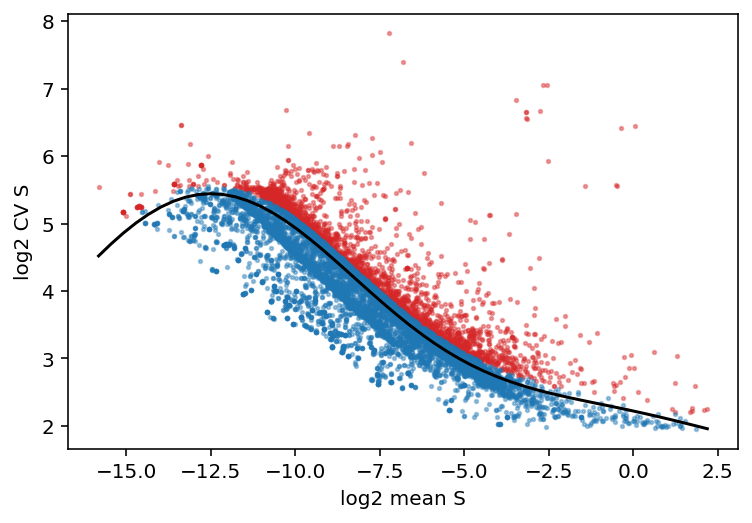

In [5]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=50, min_expr_cells=50)
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)

Define relationship between proteins and source mRNA.

In [6]:
gene_dict = {'CD3':['CD3D','CD3E','CD3G'], 
             'CD4':['CD4'],
             'CD8a':['CD8A'],
             'CD14':['CD14'], #CD15 has no protein
             'CD16':['FCGR3A','FCGR3B'],
             'CD56':['NCAM1'],
             'CD19':['CD19'],
             'CD25':['IL2RA'],
             'CD45RA':['PTPRC'],
             'CD45RO':['PTPRC'],
             'PD-1':['PDCD1'],
             'TIGIT':['TIGIT'],
             'CD127':['IL7R']}

InvertDict = lambda d: dict( (v,k) for k in d for v in d[k] )

Define inverse relationship.

In [7]:
prot_dict = InvertDict(gene_dict)
mrna_targets = list(prot_dict.keys())

Append genes that yield observed proteins even if variability is relatively low for RNA velocity phase plots. Filter genes. Save ADT names.

In [8]:
pa.enforce_protein_filter(vlm,mrna_targets,adt_names)

In [9]:
vlm.filter_genes(by_cv_vs_mean=True,by_detection_levels=True)

Filter for intersection of cell UMIs.

In [10]:
first_char = 0
last_char = 0

[prot_count_array, shared_cells, prot_cells] = pa.shared_cells_filter(vlm, prot_cells, prot_count_array, first_char, last_char)

ADT cell number: 7865
RNAseq cell number: 99333
Shared cells: 7865
Shared cells with more than 5 molecules: 7855



Perform knn imputation using protein space.

In [11]:
pa.impute(vlm, prot_count_array, k=50, impute_in_prot_space=True, size_norm=False, impute_in_pca_space=False)

Find clusters in protein space in order to ID cell types.

In [12]:
t_cl = [2,0,3,0,1,5,4,0,4,4,5,5,5]
[cluster_ID, num_clusters] = pa.identify_clusters(vlm,vlm.connectivity,
                                                  correct_tags=True,tag_correction_list=t_cl,
                                                  method_name='ModularityVertexPartition')

In [13]:
COLORS=np.asarray([[0, 0.4470, 0.7410], #CD4
                    [0.9290, 0.6940, 0.1250], #B
                    [0.4940, 0.1840, 0.5560], #Mono
                    [0.4660, 0.6740, 0.1880], #NK
                    [0.8500, 0.3250, 0.0980], #CD8
                   [240/255,15/255,223/255]
                  ])
cluster_labels = ['CD4+ T','B','Mono.','NK','CD8+ T','Misc.']
vlm.COLORS = COLORS
vlm.labels=cluster_labels

In [14]:
pa.fit_pcs(vlm,'P_norm','prot_pcs',n_pcs=4)


Visualize clusters in PC1/2 and PC2/3.

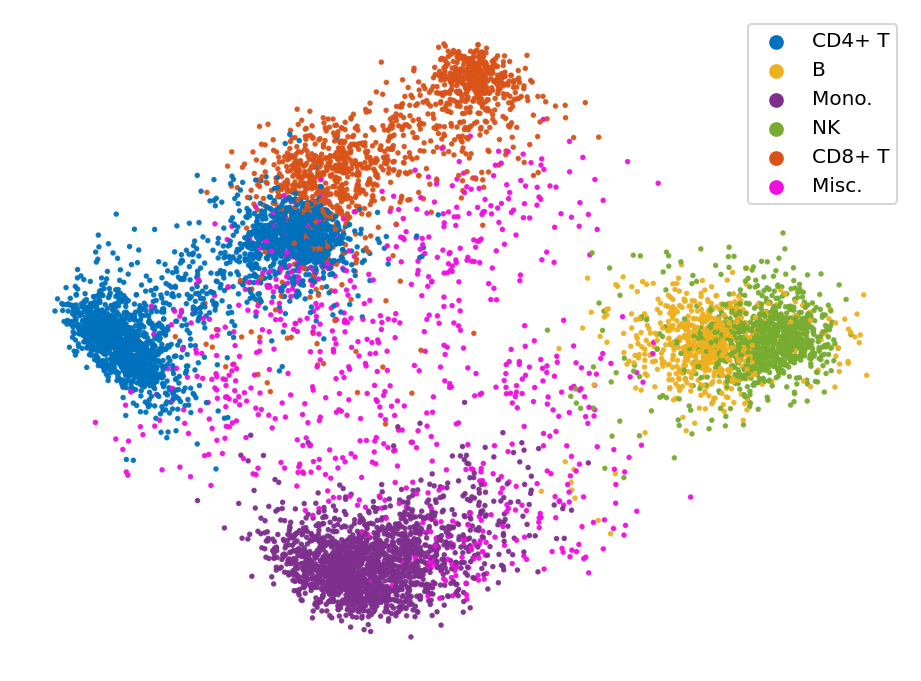

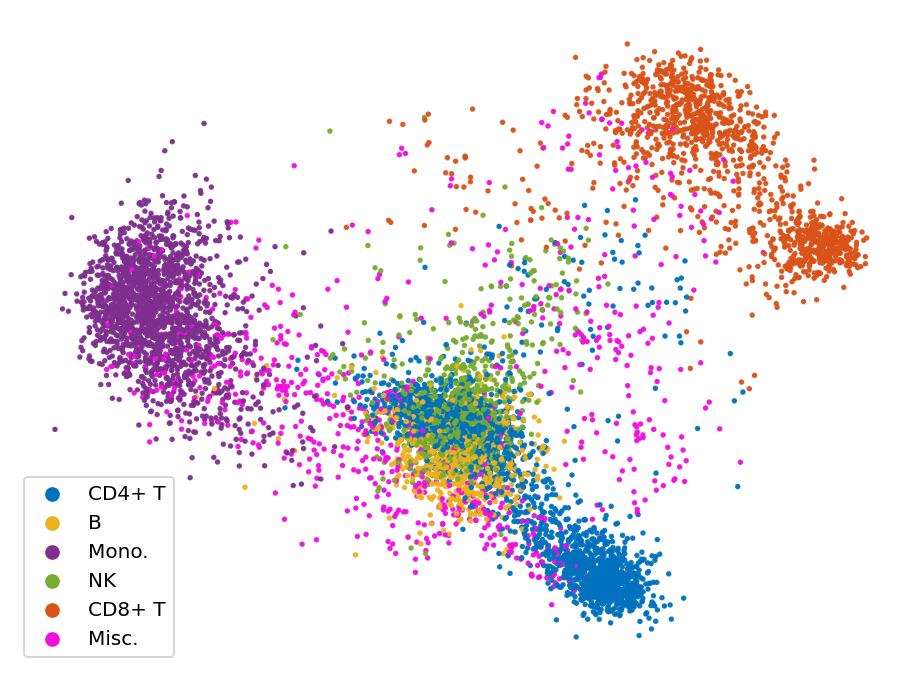

In [15]:
pa.visualize_pcs(vlm, [1,2])
pa.visualize_pcs(vlm, [2,3])

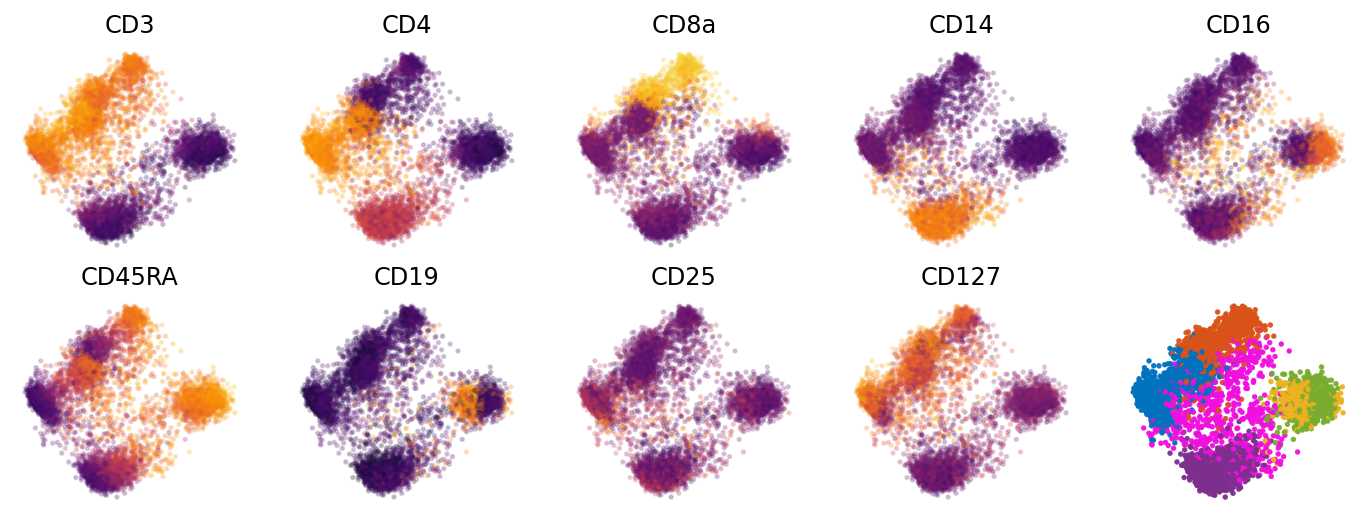

In [16]:
marker_list = ['CD3','CD4','CD8a','CD14','CD16','CD45RA','CD19','CD25','CD127']
pa.visualize_protein_markers(vlm, protein_markers=marker_list, pc_targets=[1,2], visualize_clusters= True)
plt.savefig("fig/tenX_10k_clus.svg")
# pa.visualize_protein_markers(vlm, protein_markers=marker_list, pc_targets=[2,3], visualize_clusters= True)

Visualize protein phase portraits.

In [17]:
# pa.visualize_phase_portraits(vlm, mrna_targets, target='protein', imputed=True, prot_dict=prot_dict)


Manually select RNA/protein pairs with reasonably diagonal plots for protein velocity.

In [18]:
genes_used_for_prot_velocity = ['CD3D','CD8A','NCAM1','CD14','IL2RA','IL7R','CD19','TIGIT']
adt_used_for_prot_velocity = ['CD3','CD8a','CD56','CD14','CD25','CD127','CD19','TIGIT']

Perform PCA in spliced space for embedding.

In [19]:
target_size_median = [np.median(vlm.S.sum(0)), np.median(vlm.U.sum(0))]
vlm.normalize(which="both",size=True,target_size=target_size_median)
pa.fit_pcs(vlm,'S_norm','pcs',3)

In [20]:
#pa.visualize_pcs(vlm, [1,2], pc_space='pcs')
#pa.visualize_pcs(vlm, [2,3], pc_space='pcs')


Fit degradation parameters; extrapolate.

In [21]:
pa.gamma_fit(vlm,'Sx','Ux','rna')
pa.extrapolate(vlm,vel_type='rna')

/home/vanhoan310/miniconda3/envs/umap/lib/python3.7/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


In [22]:
pa.gamma_fit(vlm,'Px','Sx','protein',genes_used_for_prot_velocity, adt_used_for_prot_velocity)
pa.extrapolate(vlm,vel_type='protein')

Examine parameter fits.

In [23]:
n_rna_velo_fit_viz = 24
np.random.seed(33)


print(str(len(vlm.rna_velo_gene_ind))+' spliced/unspliced gene pairs have diagonal phase portraits by R2. Displaying '\
      +str(n_rna_velo_fit_viz)+' random phase portraits:')
genes_for_rna_velo_fit=np.random.choice(vlm.rna_velo_gene_ind,n_rna_velo_fit_viz,replace=False)

920 spliced/unspliced gene pairs have diagonal phase portraits by R2. Displaying 24 random phase portraits:


In [24]:
rna_vel_genes=vlm.ra['Gene'][genes_for_rna_velo_fit]
# pa.visualize_phase_portraits(vlm, rna_vel_genes, target='mrna', plot_fit=True)
# plt.savefig("fig/tenX_10k_rnaphase.svg")

In [25]:
# pa.visualize_phase_portraits(vlm, mrna_targets, target='protein', imputed=True, prot_dict=prot_dict, plot_fit=True)
# plt.savefig("fig/tenX_10k_protphase.svg")

Project velocity direction into the embedding using the transition matrix method.

In [26]:
pa.identify_embedding_knn(vlm,'pcs',[1,2])

In [27]:
pa.calculate_embedding_delta(vlm,'Sx','delta_S','delta_S_in_S_pca','rna_velo_gene_ind')

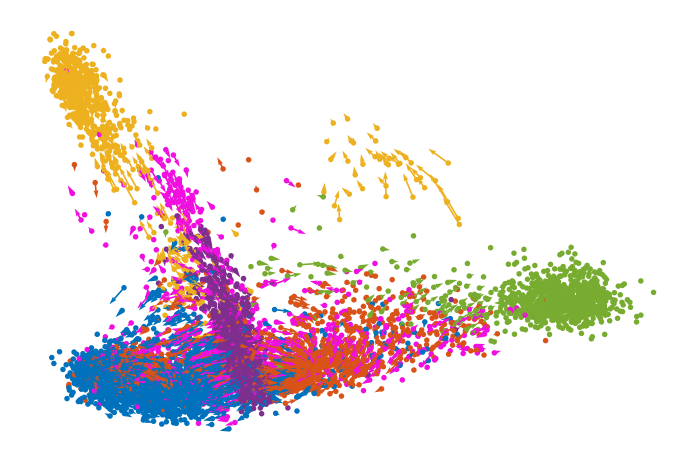

In [28]:
pa.visualize_velocity_projection(vlm, 'delta_S_in_S_pca')

In [29]:
pa.calculate_embedding_delta(vlm,'Px','delta_P','delta_P_in_S_pca','prot_velo_prot_ind')

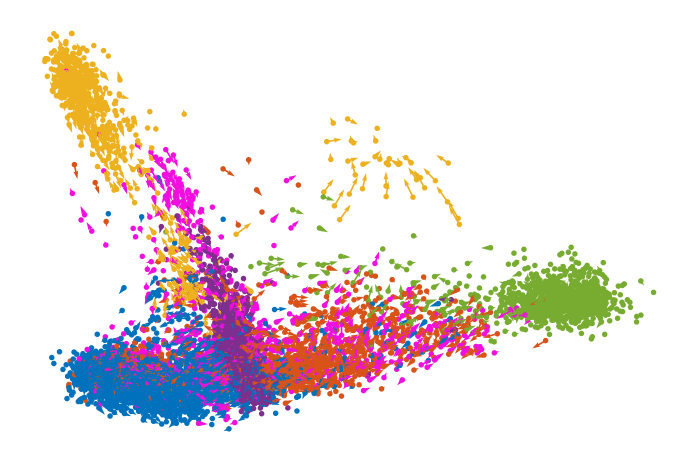

In [30]:
pa.visualize_velocity_projection(vlm, 'delta_P_in_S_pca')

Visualize cluster-specific velocities.

In [31]:
# pa.cluster_specific_plot(vlm, 'delta_S_in_S_pca',draw_cells=True)

In [32]:
# pa.cluster_specific_plot(vlm, 'delta_P_in_S_pca',draw_cells=True)

Prepare and perform grid embedding.

In [33]:
pa.initialize_grid_embedding(vlm)
uv_multiplier=1
pa.calculate_grid_arrows(vlm,'delta_S_in_S_pca', '_rna', min_mass=1,uv_multiplier=uv_multiplier)
pa.calculate_grid_arrows(vlm,'delta_P_in_S_pca', '_prot', min_mass=1,uv_multiplier=uv_multiplier)

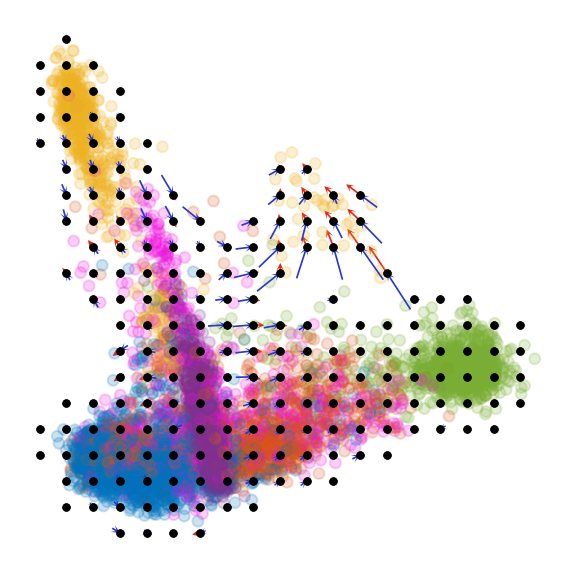

In [34]:
r_rnav = [231/255,36/255,20/255]
b_protv = [38/255,55/255,213/255]
plt.figure(figsize=(5,5))
arr_scale=1
pa.plot_grid_arrows(vlm,'UV_rna',plot_cells=False, arr_col=r_rnav,arr_scale=arr_scale)
pa.plot_grid_arrows(vlm,'UV_prot',plot_cells=True, arr_col=b_protv, color_cells_by_cluster=True, pivot='tip',
                    arr_scale=arr_scale,cell_alpha=0.2)


In [35]:
# plt.figure(figsize=(15,15))
# pa.plot_bezier(vlm, plot_cells=True, color_cells_by_cluster=True,cell_alpha=0.2)

Calculate t-SNE embedding based on normalized spliced counts. Perform analysis in t-SNE space. 

In [36]:
n_pcs_S = 25
n_pcs_P = 10
pa.fit_pcs(vlm,'S_norm','pcs_S',n_pcs_S)
pa.fit_pcs(vlm,'P_norm','pcs_P',n_pcs_P)

In [1]:
from Jvis import JUMAP
def fit_JUMAP(vlm, pc_space_name1, pc_space_name2, n_pcs1, n_pcs2, ts_name, init = 'spectral', repulsion_strength = 1.0, seed=None):
    #bh_tsne = TSNE(random_state=seed)
    data = {'X1': getattr(vlm,pc_space_name1)[:, :n_pcs1], 'X2': getattr(vlm,pc_space_name2)[:, :n_pcs2]}
    bh_tsne = JUMAP(init = init, repulsion_strength=repulsion_strength, random_state = seed).fit_transform(data)
    setattr(vlm,ts_name,bh_tsne)

In [38]:
fit_JUMAP(vlm, 'pcs_P','pcs_S', n_pcs_P,  n_pcs_S,'tsne', 'spectral', 0.05)

Always use exact mode: JUMAP


In [39]:
pa.identify_embedding_knn(vlm,'tsne',[0,1])

In [40]:
pa.calculate_embedding_delta(vlm,'Sx','delta_S','delta_S_in_S_tsne','rna_velo_gene_ind')

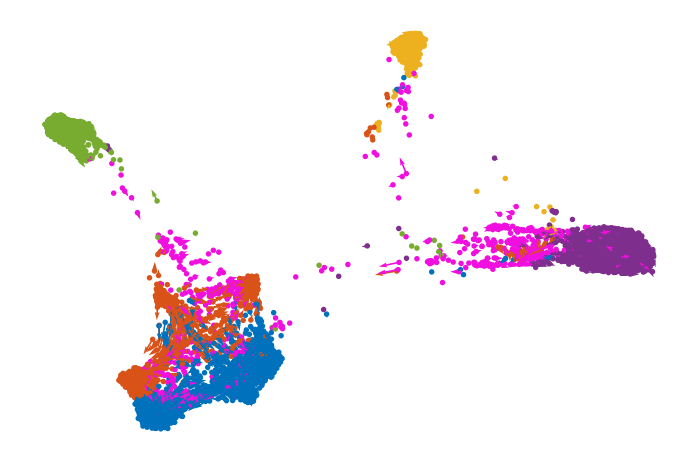

In [41]:
pa.visualize_velocity_projection(vlm, 'delta_S_in_S_tsne')


In [42]:
pa.calculate_embedding_delta(vlm,'Px','delta_P','delta_P_in_S_tsne','prot_velo_prot_ind')

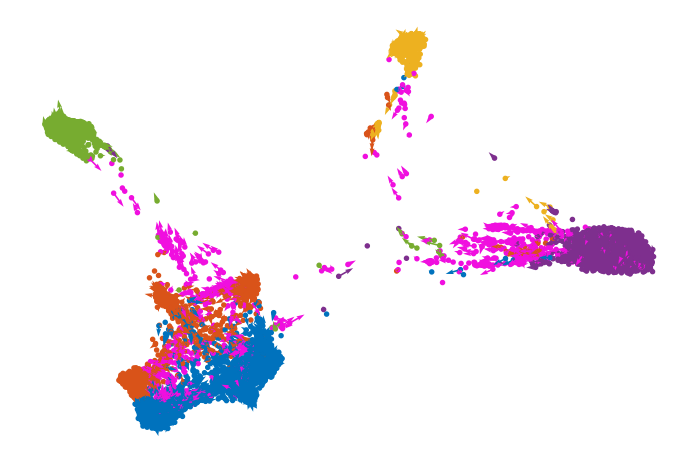

In [43]:
pa.visualize_velocity_projection(vlm, 'delta_P_in_S_tsne')


Visualize cluster-specific velocities.

In [44]:
# pa.cluster_specific_plot(vlm, 'delta_S_in_S_tsne',draw_cells=True)
# plt.savefig("fig/tenX_10k_rnav.svg")

In [45]:
# pa.cluster_specific_plot(vlm, 'delta_P_in_S_tsne',draw_cells=True)
# plt.savefig("fig/tenX_10k_protv.svg")

Prepare and perform grid embedding.

In [46]:
if hasattr(vlm,'mass_filter'):
    delattr(vlm,'mass_filter')
pa.initialize_grid_embedding(vlm, n_neighbors=20)
uv_multiplier=.1
pa.calculate_grid_arrows(vlm,'delta_S_in_S_tsne', '_rna', min_mass=0.5,uv_multiplier=uv_multiplier+0.1)
pa.calculate_grid_arrows(vlm,'delta_P_in_S_tsne', '_prot', min_mass=0.5,uv_multiplier=uv_multiplier)

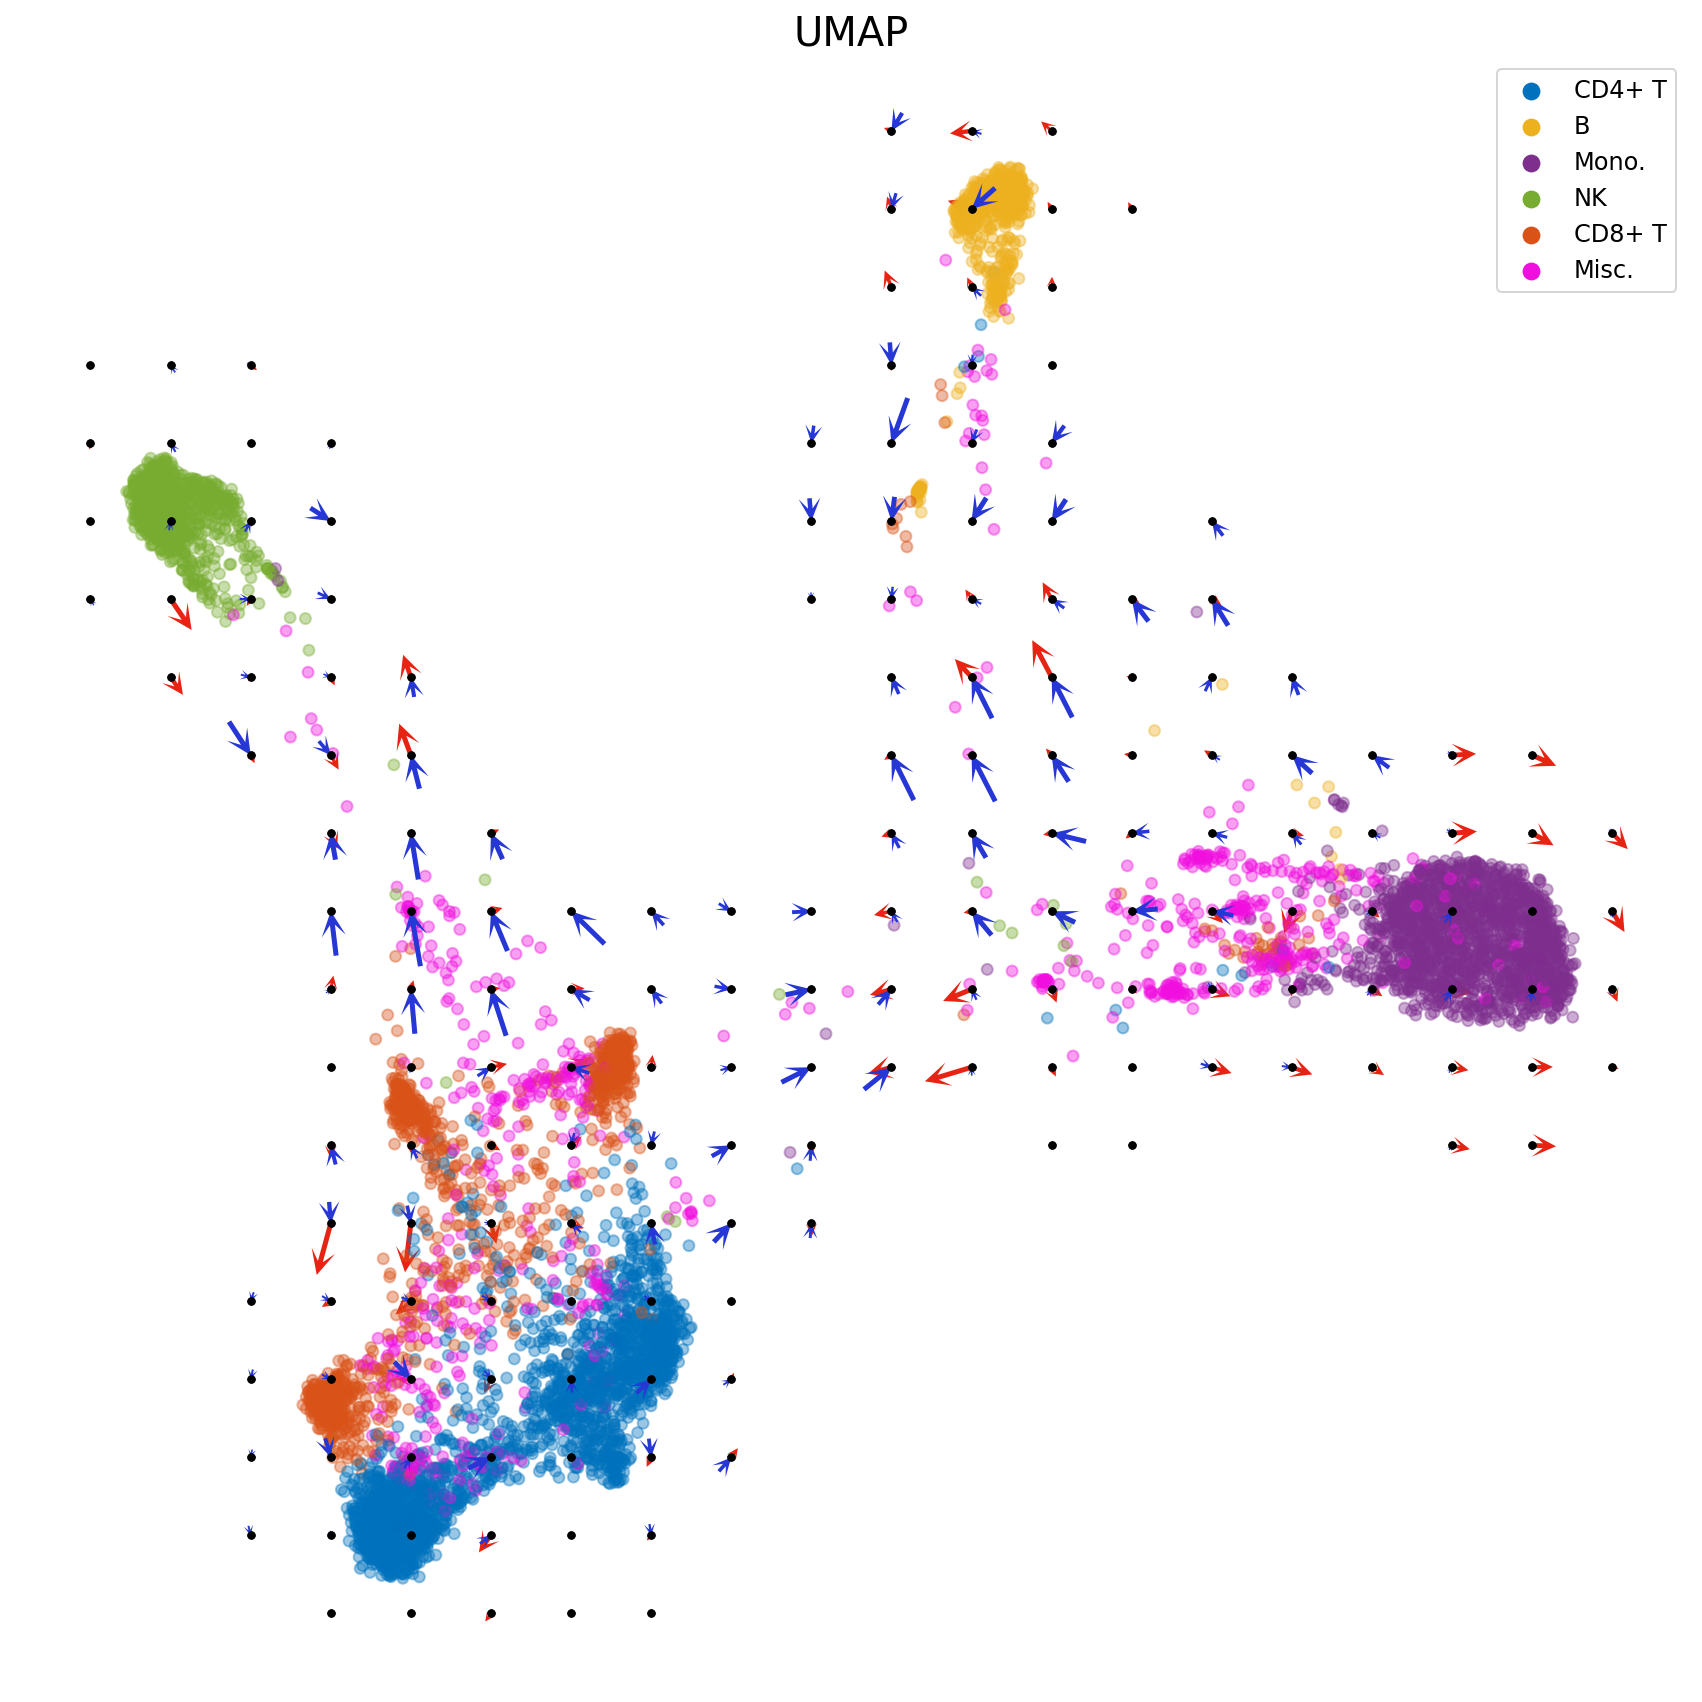

In [47]:
r_rnav = [231/255,36/255,20/255]
b_protv = [38/255,55/255,213/255]
plt.figure(figsize=(15,15))
pa.plot_grid_arrows(vlm,'UV_rna',plot_cells=False, arr_col=r_rnav,arr_scale=1)
pa.plot_grid_arrows(vlm,'UV_prot',plot_cells=True, arr_col=b_protv, color_cells_by_cluster=True, 
                    pivot='tip',cell_alpha=0.4,arr_scale=1,write_labels=True)
plt.legend(fontsize=12, markerscale=25, loc='upper right')
plt.title("UMAP", fontsize=20)
plt.savefig("/data/hoan/plots/tenX_10k_umap.pdf", bbox_inches='tight', dpi = 300)

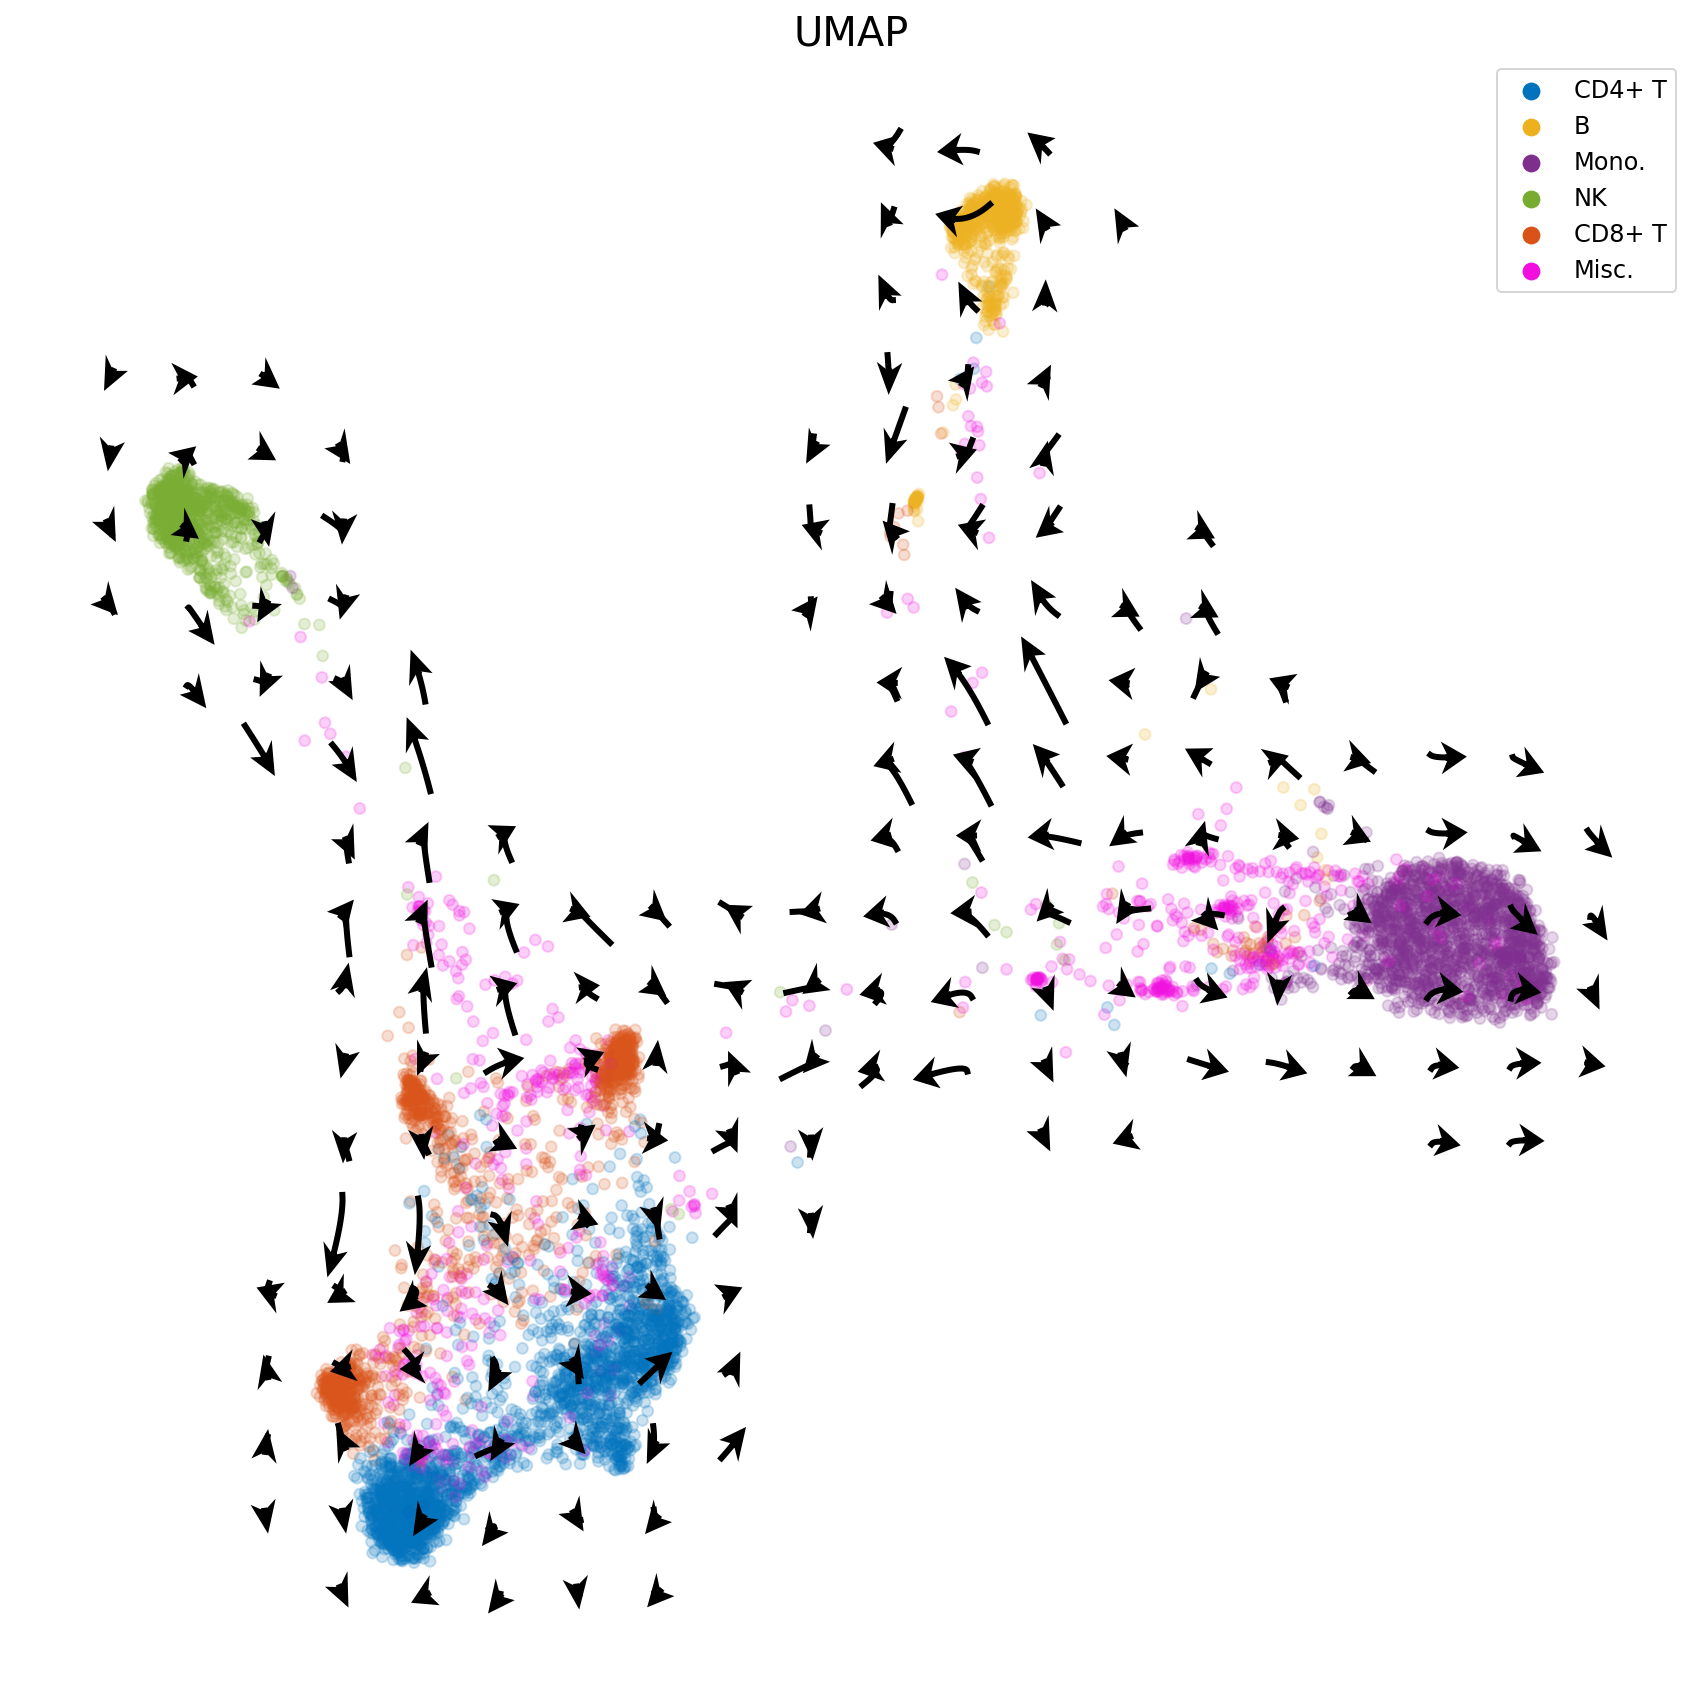

In [48]:
plt.figure(figsize=(15,15))
pa.plot_bezier(vlm, plot_cells=True, color_cells_by_cluster=True,cell_alpha=0.2,arr_len_scal=0.05,write_labels=True)
plt.legend(fontsize=12, markerscale=25, loc='upper right')
plt.title("UMAP", fontsize=20)
plt.savefig("/data/hoan/plots/tenX_10k_bez_umap.pdf", bbox_inches='tight', dpi = 300)